# [U-Net Segmentation Approach to Cancer Diagnosis](https://www.kaggle.com/c/data-science-bowl-2017#tutorial)
*approach to predicting whether a CT scan is of a patient who either has or will develop cancer within the next 12 months or not*

General Approach:
1. train a network to segment out potentially cancerous nodules
2. use the characteristics of that segmentation to make predictions about the diagnosis of the scanned patient within a 12 month time frame

# Downloading Instructions
1. **pydicom** (dicom): type in anaconda command prompt: `pip install pydicom` ([reference](http://pydicom.readthedocs.io/en/latest/getting_started.html))
2. **SimpleITK**: type in anaconda command prompt: `conda install -c https://conda.anaconda.org/simpleitk SimpleITK` ([reference](https://itk.org/Wiki/SimpleITK/GettingStarted))
3. **xgboost**: type in anaconda command prompt: `pip install xgboost` ([reference](http://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/), [long version reference](https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=en))
4. **tqdm**: type in anaconda command prompt: `pip install tqdm` ([reference](https://pypi.python.org/pypi/tqdm#usage))

## Installing Keras, Tensorflow, CuDNN, Cuda Tool Kit
*how to install keras, and the gpu supported version of tensorflow, as well as the entire GPU computing library*

**Follow the instructions [here](https://github.com/3-musketeers/kaggle-dsb/blob/master/pipeline/build-simple-model/rough-draft/model_dependency_setup.md)**

## Downloading Data
**Follow the instructions [here](https://github.com/3-musketeers/kaggle-dsb/blob/master/pipeline/build-simple-model/rough-draft/model_data_setup.md)**

# Dependency Descriptions
1. **numpy**: an extension to the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large library of high-level mathematical functions to operate on these arrays
2. **scikit-image** (skimage): collection of algorithms for image processing
3. **scikit-learn**: simple and efficient tools for data mining and data analysis
4. **keras** (tensorflow backend): high-level neural networks library, written in Python (runs on top of TensorFlow)
5. **matplotlib**: a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms
6. **pydicom** (dicom): pydicom is a pure python package for working with DICOM files such as medical images, reports, and radiotherapy objects
7. **SimpleITK**: an open-source, cross-platform system that provides developers with an extensive suite of software tools for image analysis 
8. **pandas**: providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language
9. **glob**: a module that finds all the pathnames matching a specified pattern according to the rules used by the Unix shell (results returned in arbitrary order)
10. **csv**: a module that implements classes to read and write tabular data in CSV format
11. **os**: a module that provides a portable way of using operating system dependent functionality
12. **xgboost**: a library designed and optimized for boosting trees algorithms
13. **pickle**: standard mechanism for object serialization
14. **tqdm**: instantly make your loops show a smart progress meter

## Details:
1. U-Net style convolutional network: to identify regions with nodules (U-net was designed for segmenting neuronal structures)
2. appearance on nodules within the CT scan: indicate the possibility of cancer
3. Lung Nodule Analysis 2016 (LUNA2016):
   1. provides training examples with marked nodules in order train the U Net to find these nodules (CT images with annotated nodule locations)
   2. use the LUNA data set to generate an appropriate training set for our U-Net
   3. use these examples to train our supervised segmenter

# Construct Training Set From LUNA16
*goal:*

Process:
1. use the nodule locations as given in annotations.csv and extract three transverse slices that contain the largest nodule from each patient scan
2. masks will be created for those slices based on the nodule dimensions given in annotations.csv
3. output of this file will be two files for each patient scan: a set of images and a set of corresponding nodule masks


* import tools
* find largest nodule in the patient scan
* use df_node (a pandas dataframe): to keep track of the case numbers and the node information (as there might be multiple nodule listings for some patients in annotations.csv)
* node information is an (x,y,z) coordinate in mm using a coordinate system defined in the .mhd file

In [2]:
from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import csv
import os
from glob import glob
import pandas as pd
try:
    from tqdm import tqdm # long waits are not fun
except:
    print('TQDM does make much nicer wait bars...')
    tqdm = lambda x: x

In [2]:
# will tqdm slow down the program significantly? if not then use it
for i in tqdm(range(10000000)):
    pass

100%|█████████████████████████████████████████████████████████████████| 10000000/10000000 [00:03<00:00, 2862266.25it/s]


In [3]:
# path constants
LUNA_DATA_PATH = '../../../../data/luna16/'
LUNA_SUBSET_PATH = LUNA_DATA_PATH + 'subset0/'
OUTPUT_PATH = '../../../../output/build-simple-model'
FILE_LIST = glob(LUNA_SUBSET_PATH + "*.mhd") # get all the mhd image files

# Helper function to get rows in data frame associated with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)

# The locations of the nodes
df_node = pd.read_csv(LUNA_DATA_PATH + "annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(FILE_LIST, file_name)) # for every row, save file name to the 'file' column of the row
df_node = df_node.dropna() # if the seriesuid is not found in this subset, drop all the rows that have na as values for 'file' column

In [4]:
img_file = FILE_LIST[2] # using only file_list[2] as example in rest of code
itk_img = sitk.ReadImage(img_file) # using sitk to read a .mhd image
print(itk_img)

Image (000002AD21F6DAA0)
  RTTI typeinfo:   class itk::Image<short,3>
  Reference Count: 1
  Modified Time: 1060
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1035
  UpdateMTime: 1059
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 161]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 161]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 161]
  Spacing: [0.548828, 0.548828, 1.25]
  Origin: [-187.7, -108.3, -194]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.548828 0 0
0 0.548828 0
0 0 1.25

  PointToIndexMatrix: 
1.82206 0 0
0 1.82206 0
0 0 0.8

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (000002AD2090BA70)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int

In [5]:
# get the associated 3d pixel array for the .mhd image
img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
print(img_array)

[[[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]]

 [[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]]

 [[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]]

 ..., 
 [[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -

In [6]:
num_z, height, width = img_array.shape
origin = np.array(itk_img.GetOrigin())      # x,y,z Origin in world coordinates (mm)
spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coordinates (mm)
print(num_z)
print(height)
print(width)
print(origin)
print(spacing)

161
512
512
[-187.699997 -108.300003 -194.      ]
[ 0.54882801  0.54882801  1.25      ]


In [7]:
mini_df = df_node[df_node["file"]==FILE_LIST[2]] # get all nodules associate with file
print(mini_df)
print('\n')
for node_idx, cur_row in mini_df.iterrows(): # .iterrows() generates (indices, row)
    print(node_idx)
    print(cur_row)

                                            seriesuid     coordX     coordY  \
25  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...  46.188539  48.402806   
26  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...  36.392044  76.771663   

        coordZ  diameter_mm                                               file  
25 -108.578632    13.596471  ../../../../data/luna16/subset0\1.3.6.1.4.1.14...  
26 -123.321911     4.343200  ../../../../data/luna16/subset0\1.3.6.1.4.1.14...  


25
seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...
coordX                                                   46.1885
coordY                                                   48.4028
coordZ                                                  -108.579
diameter_mm                                              13.5965
file           ../../../../data/luna16/subset0\1.3.6.1.4.1.14...
Name: 25, dtype: object
26
seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...
coordX                          

In [8]:
for node_idx, cur_row in mini_df.iterrows():
    node_x = cur_row["coordX"]
    node_y = cur_row["coordY"]
    node_z = cur_row["coordZ"]
    diam = cur_row["diameter_mm"]
    print(node_x)
    print(node_y)
    print(node_z)
    print(diam)
    
    # just keep 3 slices
    imgs = np.ndarray([3,height,width],dtype=np.float32) # merely defining the final product
    masks = np.ndarray([3,height,width],dtype=np.uint8) # note the random array (it will be overwritten)
    center = np.array([node_x, node_y, node_z])   # nodule center
    v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
    print(imgs)
    print(masks)
    print(center)
    print(v_center)
    break # only do it for the first node

46.18853869
48.40280596
-108.5786324
13.59647134
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
[[[ 80   1 100 ...,   1   0   0]
  [ 84   1   0 ...,   3   0   0]
  [212   3   0 ...,   6   0   0]
  ..., 
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]]

 [[  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  ..., 
  [  0   0  

In [9]:
print(v_center[2]) # the slice at which the center of the nodule is located
print(v_center[2]-1) # one slice below
# center will never be at the bottom so a clip is not needed
print(v_center[2]+2) # two slices above
# clip needed because you could go over the total number of slices
for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
    print(i)
    print(i_z)

68.0
67.0
70.0
0
67
1
68
2
69


In [10]:
# mask = make_mask(center, diam, i_z*spacing[2]+origin[2], width, height, spacing, origin)
i = 0
i_z = 67
print(center) # center comes in real world coordinates, using spacing and origin will convert it to voxel (in terms of the image)
print(diam)
print(i_z*spacing[2]+origin[2])
print(width)
print(height)
print(spacing)
print(origin)

[  46.18853869   48.40280596 -108.5786324 ]
13.59647134
-110.25
512
512
[ 0.54882801  0.54882801  1.25      ]
[-187.699997 -108.300003 -194.      ]


In [11]:
def make_mask(center,diam,z,width,height,spacing,origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    # since everything comes in real world coordinates, you need to convert to voxel to be able to work with the pixels
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5) # increase diameter by 5 to get pixels around nodule
    # the question is why not just add 10 to v_diam and avoid doing the stuff below (with the -5 and +5?)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5]) # subtract 5 again so now the radius is diam + 10
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])
    # we don't want just the pixels of the nodule, we want the pixels around it as well to be able to identify it
    # these are calculations using the voxel coordinates, and they always have bigger spacing compared to real world spacing
    
    v_xrange = range(v_xmin,v_xmax+1) # why add 1?
    v_yrange = range(v_ymin,v_ymax+1) # add 1 because you are using it as a range attribute (if you don't add 1 then you will not be able to get the last pixel in the range due to the way range works)

    # this part of the code is not used anywhere else
    # Convert back to world coordinates for distance calculation
    # x_data = [x*spacing[0]+origin[0] for x in range(width)]
    # y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # the range at this point contains a lot more than just what is within the diameter (since the voxel coord>real coord) 
    # so this first narrows down which ones are within the diameter, then makes them 1
    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0] # change to real world coordinates
            p_y = spacing[1]*v_y + origin[1]
            # linalg compares all 3 values and if any of them are not <= it is false
            # compare the real world coordinates to see if pixel lies within diameter
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam: # if this is true, it is within the radius so set it equal to 1
                # convert the real world back to voxel coordinates to save 1 as value
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0 # this is the coordinate of the pixel in the mask
    # this will run through all the likely pixels, and make the ones that are within 1 diameter of the center of the nodule 1 
    # creates a black and white mask where 1 is where the nodule is
    return(mask)

In [12]:
fcount = 1
node_idx = 25
"masks_%04d_%04d.npy" % (fcount, node_idx) # the 4 tells the number of digits and the numbers replace the 0s
# is this going to be an issue for unique identification? as you will be reusing fcount for all of the subset files?
# it will not be an issue as node_idx is a unique identifier on its own (unique number for each node)
# fcount is kind of useless

'masks_0001_0025.npy'

In [3]:
LUNA_DATA_PATH = '../../../../data/luna16/'
LUNA_SUBSET_PATH = LUNA_DATA_PATH + 'subset0/'
OUTPUT_PATH = '../../../../output/build-simple-model'
FILE_LIST = glob(LUNA_SUBSET_PATH + '*.mhd')

In [4]:
for num in range(0, 4):
    print("subset" + str(num) + ": " + str(len(glob(LUNA_DATA_PATH + 'subset' + str(num) + '/' + '*.mhd'))))

subset0: 89
subset1: 89
subset2: 89
subset3: 89


In [6]:
print(FILE_LIST[0])

../../../../data/luna16/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd


In [6]:
for i in range(0, 3):
    LUNA_SUBSET_PATH = LUNA_DATA_PATH + 'subset'+str(i)+'/'
    print(LUNA_SUBSET_PATH)

../../../../data/luna16/subset0/
../../../../data/luna16/subset1/
../../../../data/luna16/subset2/


In [28]:
a = np.ones([2,3]) # yields 2x3 (rows, columns)
b = np.ones([2,3,4]) # yields 2x3x4 (z, rows, columns)
print(a)
print(b)
b[0,0] = np.zeros([1,4])
print(b)

[[ 1.  1.  1.]
 [ 1.  1.  1.]]
[[[ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]]

 [[ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]]]
[[[ 0.  0.  0.  0.]
  [ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]]

 [[ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]]]


In [37]:
a = ['a', 'a']
b = ['b', 'b']
c = [a]
c.append(b)
print(c)

FILE_LIST = []

for i in range(0, 3):
    LUNA_SUBSET_PATH = LUNA_DATA_PATH + 'subset'+str(i)+'/'
    FILE_LIST.append(glob(LUNA_SUBSET_PATH + '*.mhd'))
print(len(FILE_LIST))

[['a', 'a'], ['b', 'b']]
3


In [39]:
for subsetnum, subsetlist in enumerate(FILE_LIST):
    print(subsetnum)
    print(len(subsetlist))

0
89
1
89
2
89


## Checking Success of Code

number of images: 184
../../../../output/build-simple-model\images_0000_0001_0023.npy


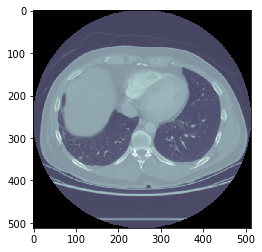

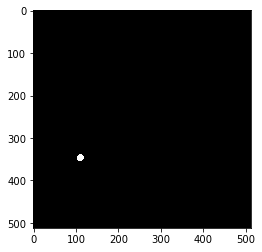

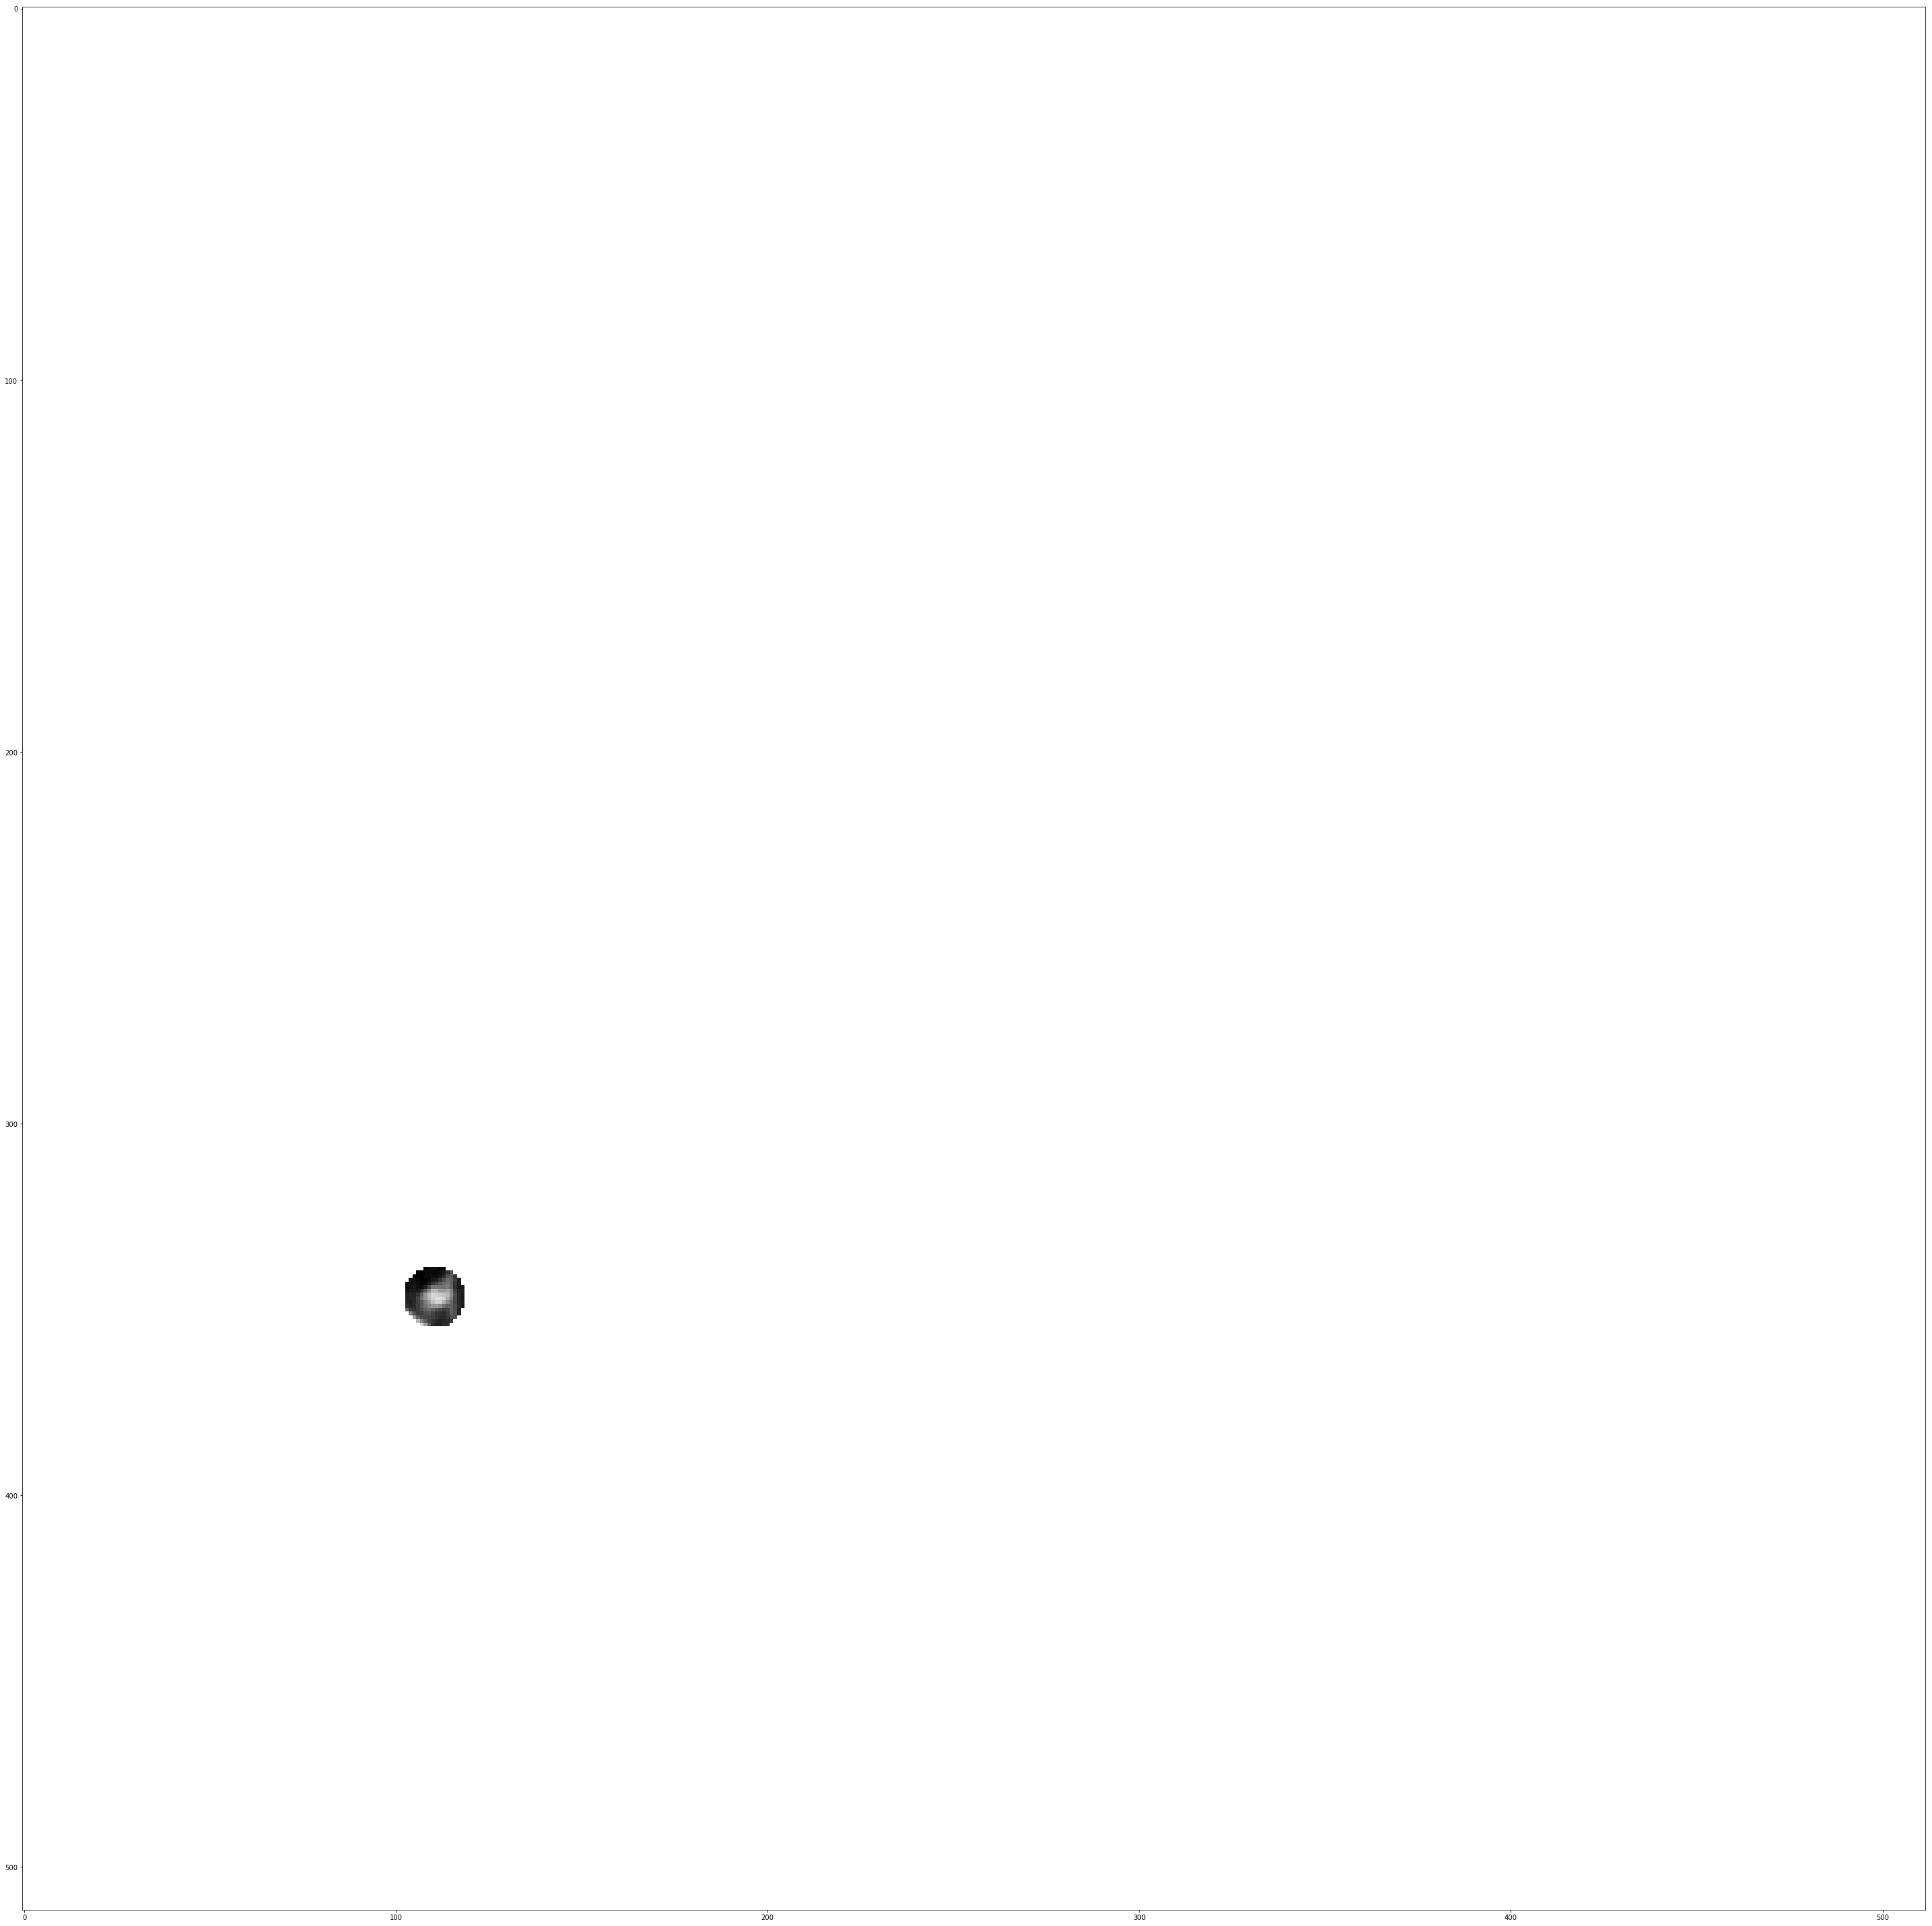

In [73]:
import pylab
from matplotlib.figure import Figure

FILE_LIST = glob(OUTPUT_PATH + '/' + 'images' + '*.npy')
print("number of images: " + str(len(FILE_LIST)))
for i, imgfilepath in enumerate(FILE_LIST):
    print(imgfilepath)
    maskfilepath = imgfilepath.replace('images', 'masks')
    # print(maskfilepath)
    imgfile = np.load(imgfilepath)
    maskfile = np.load(maskfilepath)
    # print(imgfile[0].ndim)
    pylab.imshow(imgfile[0], cmap=pylab.cm.bone) 
    pylab.show()
    pylab.imshow(maskfile[0], cmap=pylab.cm.bone) 
    pylab.show()
    applied_mask = np.ndarray(imgfile[0].shape)
    for i in range(len(imgfile[0])):
        applied_mask[i] = imgfile[0][i] * maskfile[0][i]
        
    fig = pylab.figure(figsize = (52,52))
    ax = fig.add_subplot(111)
    ax.imshow(applied_mask, cmap='gray')
    pylab.show()
    break

Success confirmed, when you run a major portion of the for loop, it yields acurate node masks